Reference: 
1. Ideas of Quantum Chemistry, Appendix P. Molecular integrals with Gaussian type orbital 1s
2. Evaluation of Gaussian Molecular Integrals  I Overlap Integrals

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, sqrt, pi

def double_factorial(n):
    """Calculate the double factorial of n (n!!)."""
    if n <= 0:
        return 1
    return np.prod(range(n, 0, -2))

def gaussian_product_center(alpha, A, beta, B):
    """Calculate the Gaussian product center P for two Gaussians centered at A and B with exponents alpha and beta."""
    return (alpha * A + beta * B) / (alpha + beta)

def overlap_component(ax, bx, alpha, beta, A, B):
    """Calculate the overlap integral component S_x, S_y, or S_z."""
    P = gaussian_product_center(alpha, A, beta, B)
    gamma = alpha + beta
    prefactor = sqrt(pi / gamma)
    S_component = 0.0

    # Binomial expansion of (x - A)^a (x - B)^b
    for i in range(ax + 1):
        for j in range(bx + 1):
            if (i + j) % 2 != 0:
                # Skip terms where i + j is odd (they integrate to zero)
                continue
            coef = (factorial(ax) // (factorial(i) * factorial(ax - i))) * \
                   (factorial(bx) // (factorial(j) * factorial(bx - j)))
            term = coef * (P - A)**(ax - i) * (P - B)**(bx - j)
            S_component += term * double_factorial(i + j - 1) / (2 * gamma)**((i + j) / 2)

    return prefactor * S_component

def overlap_integral(alpha, a, A, beta, b, B):
    """Calculate the overlap integral S for two Cartesian Gaussians centered at A and B."""
    E_AB = np.exp(-alpha * beta / (alpha + beta) * np.sum((A - B)**2))
    Sx = overlap_component(a[0], b[0], alpha, beta, A[0], B[0])
    Sy = overlap_component(a[1], b[1], alpha, beta, A[1], B[1])
    Sz = overlap_component(a[2], b[2], alpha, beta, A[2], B[2])
    return E_AB * Sx * Sy * Sz

# Example usage with STO-3G parameters for Helium 1s and 2s orbitals

# Define exponents and centers
alpha = 6.3624  # Example exponent for 1s orbital
beta = 1.1589   # Example exponent for 2s orbital
A = np.array([0.0, 0.0, 0.0])  # Center of 1s orbital on Helium
B = np.array([0.0, 0.0, 0.0])  # Center of 2s orbital on Helium

# Define Cartesian angular momentum (1s and 2s are s orbitals, so [0, 0, 0])
a = [0, 0, 0]  # Angular momentum for 1s
b = [0, 0, 0]  # Angular momentum for 2s

In [22]:
# Calculate overlap integral
S = overlap_integral(alpha, a, A, beta, b, B)
print("Overlap Integral S:", S)

Overlap Integral S: 0.26995131143371076


In [ ]:
# Define the core Hamiltonian matrix H_core (example values for 1s and 2s)
H_core = np.array([
    [1.2565, 0.4000],  # H(1s,1s) and H(1s,2s)
    [0.4000, 0.8000]   # H(2s,1s) and H(2s,2s)
])

# Define two-electron integrals (Coulomb and exchange terms) for 1s and 2s orbitals
I = np.zeros((2, 2, 2, 2))
I[0, 0, 0, 0] = 0.7746  # (1s,1s|1s,1s)
I[0, 0, 1, 1] = 0.5697  # (1s,1s|2s,2s)
I[1, 1, 0, 0] = 0.5697  # (2s,2s|1s,1s)
I[1, 1, 1, 1] = 0.7746  # (2s,2s|2s,2s)
I[0, 1, 0, 1] = 0.4441  # (1s,2s|1s,2s)

# SCF parameters
num_iter = 50
tolerance = 1e-10
num_orbitals = H_core.shape[0]

# Initial guess for the density matrix
D = np.array([[0.5, 0.1], [0.1, 0.5]])

# Define the overlap matrix S for 1s and 2s orbitals (example values)
S = np.array([
    [1.0, 0.2],  # Overlap between 1s and 1s, and 1s and 2s
    [0.2, 1.0]   # Overlap between 2s and 1s, and 2s and 2s
])

def compute_fock_matrix(D):
    F = H_core.copy()
    for i in range(num_orbitals):
        for j in range(num_orbitals):
            F[i, j] += np.sum(D * (2 * I[i, j] - I[i, :, :, j]))
    return F

In [16]:
# Lists to track convergence data
total_energy_list = []
orbital_energies_list = []

# SCF loop
for iteration in range(num_iter):
    # Compute Fock matrix based on current density matrix
    F = compute_fock_matrix(D)

    # Inside the SCF loop, use S to transform the Fock matrix
    # Diagonalize S to get orthonormalization transformation
    eigvals, eigvecs = np.linalg.eigh(S)
    S_inv_sqrt = eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T  # S^(-1/2)

    # Transform Fock matrix F to orthonormal basis
    F_orthogonal = S_inv_sqrt @ F @ S_inv_sqrt
    
    # Diagonalize the Fock matrix to get molecular orbital energies and coefficients
    orbital_energies, C = np.linalg.eigh(F_orthogonal)
    
    # Form the new density matrix using the molecular orbital coefficients
    D_new = np.zeros_like(D)
    for i in range(num_orbitals):
        for j in range(num_orbitals):
            D_new[i, j] = 2 * np.sum(C[i, :] * C[j, :])
    
    # Compute electronic energy
    E_electronic = np.sum((D * (H_core + F)).flatten())
    
    # Store convergence data
    total_energy_list.append(E_electronic)
    orbital_energies_list.append(orbital_energies.copy())
    
    # Check for convergence
    if np.allclose(D, D_new, atol=tolerance):
        print(f"Converged at iteration {iteration}")
        break
    
    # Update the density matrix for the next iteration
    D = D_new.copy()


# Convert orbital energies list to a numpy array for easy plotting
orbital_energies_list = np.array(orbital_energies_list)

Converged at iteration 1


In [18]:
C

array([[-0.56367149, -0.82599907],
       [-0.82599907,  0.56367149]])

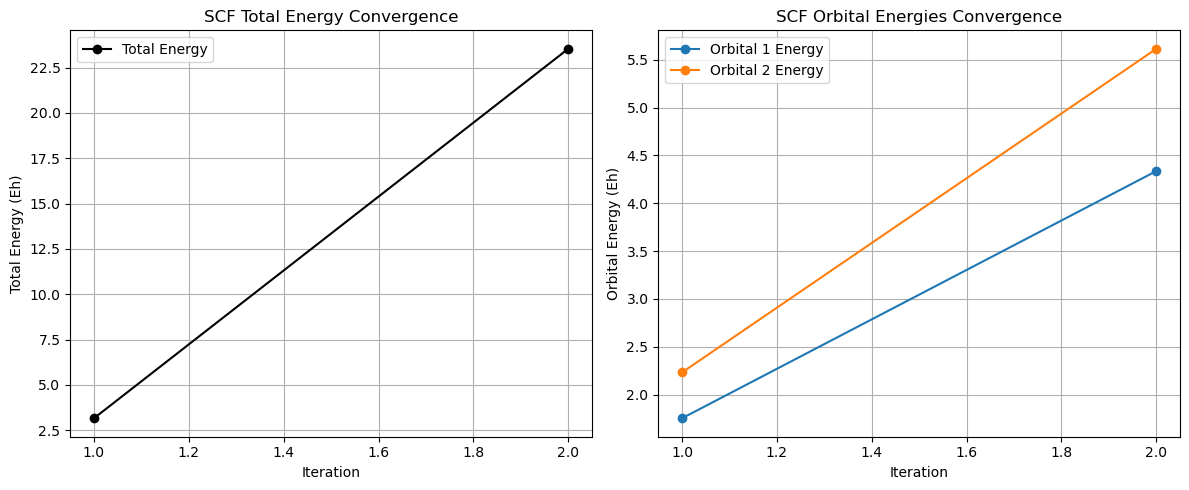

Final electronic energy: 23.538000000000007
Orbital energies: [4.33623319 5.61428764]


In [17]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot total energy convergence
ax[0].plot(range(1, len(total_energy_list) + 1), total_energy_list, 'k-o', label='Total Energy')
ax[0].set_title('SCF Total Energy Convergence')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Total Energy (Eh)')
ax[0].grid(True)
ax[0].legend()

# Plot orbital energies convergence for each orbital
for i in range(orbital_energies_list.shape[1]):
    ax[1].plot(range(1, len(orbital_energies_list) + 1), orbital_energies_list[:, i], 'o-', label=f'Orbital {i+1} Energy')
ax[1].set_title('SCF Orbital Energies Convergence')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Orbital Energy (Eh)')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

# Output final results
print("Final electronic energy:", total_energy_list[-1])
print("Orbital energies:", orbital_energies_list[-1])